In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python3)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: build: File exists
-- The C compiler identification is AppleClang 11.0.3.11030032
-- The CXX compiler identification is AppleClang 11.0.3.11030032
-- Check for working C compiler: /Library/Developer/CommandLineTools/usr/bin/cc
-- Check for working C compiler: /Library/Developer/CommandLineTools/usr/bin/cc - works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /Library/Developer/CommandLineTools/usr/bin/c++
-- Check for working CXX compiler: /Library/Developer/CommandLineTools/usr/bin/c++ - works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /usr/local/bin/python3 (found version "3.7.7") 
-- Found PythonLibs: /usr/local/opt/python/Frameworks/Python.framework/Versions/3.7/lib/libpython3.7m.dylib
-- pybind11 v2.5

In [1]:
import math 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d
from sklearn.linear_model import LinearRegression

In [2]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum

/Users/mariano.benzo/Facultad/Metodos/TP3/metnum-tp3/notebooks
Python 2.7.16


## Linear Regression Predict

In [3]:
def linearRegressorPredict(df_train, df_test, cs, cPred):
    x = df_train[cs].values
    y = df_train[cPred].values
    x = x.reshape(len(x), x.shape[1])
    y = y.reshape(len(y), 1)

    linear_regressor = metnum.LinearRegression()
    linear_regressor.fit(x,y)

    x = df_test[cs].values
    x = x.reshape(len(x), x.shape[1])
    
    df_test[cPred] = linear_regressor.predict(x)
    
    df_test = df_test[df_test[cPred] < 0].dropna()


## K-Fold Cross-Validation

In [4]:
def splitTrainSet(x, y, K, i):
    size = int(x.shape[0] * 1/K)
    
    x_train1 = x[:i * size]
    x_train2 = x[(i + 1) * size:]
    x_train = np.concatenate((x_train1, x_train2))
    x_test = x[i * size:(i + 1) * size]
    
    y_train1 = y[:i * size]
    y_train2 = y[(i + 1) * size:]
    y_train = np.concatenate((y_train1, y_train2))
    y_test = y[i * size:(i + 1) * size]
    
    return x_train, y_train, x_test, y_test

In [5]:
from sklearn.linear_model import LinearRegression

def linearRegressionKFoldErrors(df_train, cs, cPred, K):
    
    x = df_train[cs].values
    y = df_train[cPred].values
    x = x.reshape(len(x), x.shape[1])
    y = y.reshape(len(y), 1)

    RMSE = []
    RMSLE = []
    
    for i in range(0, K):
        x_train, y_train, x_test, y_test = splitTrainSet(x, y, K, i)
                
        linear_regressor = metnum.LinearRegression()

        linear_regressor.fit(x_train, y_train)
        
        y_pred = linear_regressor.predict(x_test)
        
        y_test, y_pred = deleteNegativeElements(y_test, y_pred)
            
        e = linearRegressorRMSE(y_test, y_pred)
        le = linearRegressorRMSLE(y_test, y_pred)

        RMSE.append(e)
        RMSLE.append(le)

    RMSE = np.mean(RMSE)
    RMSLE = np.mean(RMSLE)

    return RMSE, RMSLE

In [6]:
def deleteNegativeElements(y_test, y_pred):
    negativeIndex = []
    for i in range(0, len(y_pred)):
        if (y_pred[i] < 0 or y_test[i] < 0):
            negativeIndex.append(i)

    for index in negativeIndex:
        y_pred = np.delete(y_pred, index)
        y_test = np.delete(y_test, index)
            
    return y_test, y_pred

## RMSE & RMSLE

In [7]:
def linearRegressorRMSE(y_test, y_pred):
    n = len(y_test)
    return math.sqrt(sum([(y_test[i] - y_pred[i])**2 for i in range(0, n)]) / n)

In [8]:
def linearRegressorRMSLE(y_test, y_pred):
    n = len(y_test)    
    return math.sqrt(sum([(math.log(y_test[i] + 1) - (math.log(y_pred[i] + 1)))**2 for i in range(0, n)]) / n)

## Figures 2D & 3D

In [9]:
def linearRegressorFigure2D(df_train, df_test, c1, cPred):
    sns.scatterplot(data=df_train, x=c1, y=cPred)
    sns.lineplot(data=df_test, x=c1, y=cPred, color='red')

In [10]:
def linearRegressorFigure3D(df_train, df_test, c1, c2, cPred):
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    xline = df_test[c1].values
    yline = df_test[c2].values
    zline = df_test[cPred].values
    ax.plot_trisurf(xline, yline, zline, color='red', alpha=0.5)

    xdata = df_train[c1].values
    ydata = df_train[c2].values
    zdata = df_train[cPred].values
    ax.scatter3D(xdata, ydata, zdata, edgecolors='blue')

    ax.set_xlabel(c1)
    ax.set_ylabel(c2)
    ax.set_zlabel(cPred)

## Experimentacion

### Test 1

In [60]:
df_train = pd.read_csv('../data/train.csv')
df_train = df_train[df_train['provincia']=='Jalisco'].dropna()
df_train = df_train[(df_train['tipodepropiedad']=='Casa') | (df_train['tipodepropiedad']=='Apartamento')].dropna()

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

In [61]:
K = 5
RMSE, RMSLE = linearRegressionKFoldErrors(df_train, ['metroscubiertos', 'metrostotales'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)

RMSE:  960065.7320034578
RMSLE:  0.427736651518999


In [62]:
linearRegressorPredict(df_train, df_test, ['metroscubiertos', 'metrostotales'], 'precio')

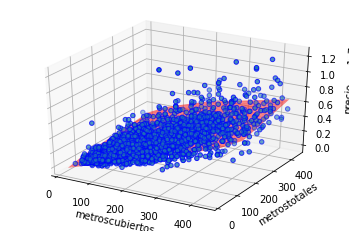

In [63]:
linearRegressorFigure3D(df_train, df_test, 'metroscubiertos', 'metrostotales', 'precio')

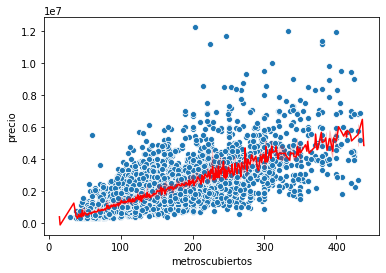

In [64]:
linearRegressorFigure2D(df_train, df_test, 'metroscubiertos', 'precio')

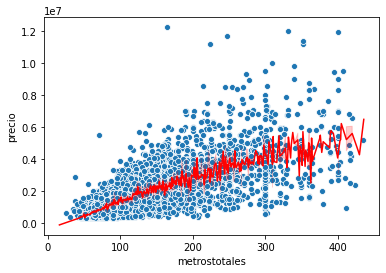

In [65]:
linearRegressorFigure2D(df_train, df_test, 'metrostotales', 'precio')

### Test 2

In [66]:
df_train = pd.read_csv('../data/train.csv')
df_train = df_train[df_train['provincia']=='Jalisco'].dropna()
df_train = df_train[(df_train['tipodepropiedad']=='Casa') | (df_train['tipodepropiedad']=='Apartamento')].dropna()

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

In [67]:
K = 5
RMSE, RMSLE = linearRegressionKFoldErrors(df_train, ['habitaciones', 'banos', 'piscina', 'garages'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)

RMSE:  1131353.6037798123
RMSLE:  0.6210052199627413


In [68]:
linearRegressorPredict(df_train, df_test, ['habitaciones', 'banos', 'piscina', 'garages'], 'precio')

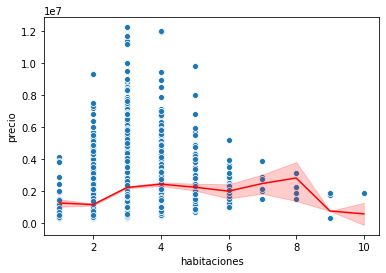

In [69]:
linearRegressorFigure2D(df_train, df_test, 'habitaciones', 'precio')

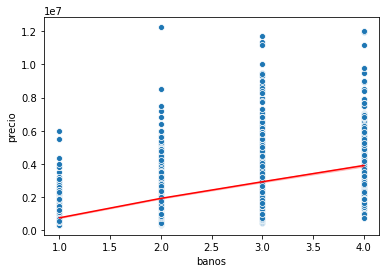

In [70]:
linearRegressorFigure2D(df_train, df_test, 'banos', 'precio')

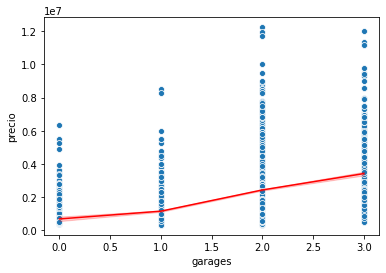

In [71]:
linearRegressorFigure2D(df_train, df_test, 'garages', 'precio')

### Test 3

In [17]:
df_train = pd.read_csv('../data/train.csv')
df_train = df_train[df_train['provincia']=='Distrito Federal'].dropna()
df_train = df_train[(df_train['tipodepropiedad']=='Casa') | (df_train['tipodepropiedad']=='Apartamento')].dropna()

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

In [18]:
K = 5
RMSE, RMSLE = linearRegressionKFoldErrors(df_train, ['antiguedad'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)

RMSE:  2169474.1958515216
RMSLE:  0.7663143014691368


In [19]:
linearRegressorPredict(df_train, df_test, ['antiguedad'], 'precio')

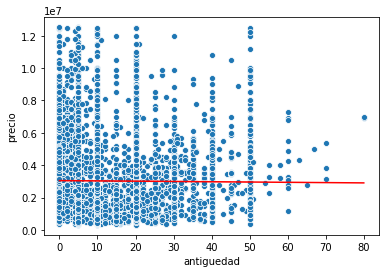

In [20]:
linearRegressorFigure2D(df_train, df_test, 'antiguedad', 'precio')

In [21]:
df_train = pd.read_csv('../data/train.csv')
df_train = df_train[df_train['provincia']=='Distrito Federal'].dropna()
df_train = df_train[(df_train['tipodepropiedad']=='Casa') | (df_train['tipodepropiedad']=='Apartamento')].dropna()
df_train = df_train[df_train['antiguedad'] <= 20].dropna()

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

In [22]:
K = 5
RMSE, RMSLE = linearRegressionKFoldErrors(df_train, ['antiguedad'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)

RMSE:  2175348.344991418
RMSLE:  0.7702308315140565


In [23]:
linearRegressorPredict(df_train, df_test, ['antiguedad'], 'precio')

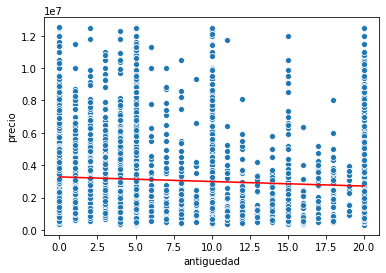

In [24]:
linearRegressorFigure2D(df_train, df_test, 'antiguedad', 'precio')

In [25]:
df_train = pd.read_csv('../data/train.csv')
df_train = df_train[df_train['provincia']=='Distrito Federal'].dropna()
df_train = df_train[(df_train['tipodepropiedad']=='Casa') | (df_train['tipodepropiedad']=='Apartamento')].dropna()
df_train = df_train[df_train['antiguedad'] > 20].dropna()

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

In [26]:
K = 5
RMSE, RMSLE = linearRegressionKFoldErrors(df_train, ['antiguedad'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)

RMSE:  1973669.9111427013
RMSLE:  0.6659935349591212


In [27]:
linearRegressorPredict(df_train, df_test, ['antiguedad'], 'precio')

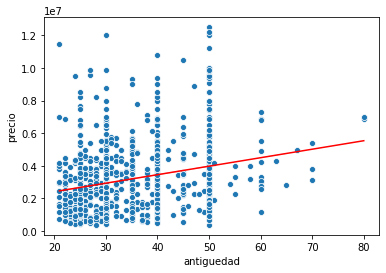

In [28]:
linearRegressorFigure2D(df_train, df_test, 'antiguedad', 'precio')

### Test 4

In [93]:
df_train = pd.read_csv('../data/train.csv')
df_train = df_train[(df_train['tipodepropiedad']=='Casa') | (df_train['tipodepropiedad']=='Apartamento')].dropna()
df_train = df_train[(df_train['lng']>-130.0) & (df_train['lng']<-80.0)].dropna()
df_train = df_train[(df_train['lat']>5.0) & (df_train['lat']<50.0)].dropna()

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

In [94]:
K = 5
RMSE, RMSLE = linearRegressionKFoldErrors(df_train, ['lat', 'lng'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)

RMSE:  1759657.4266750873
RMSLE:  0.8177213681870962


In [95]:
linearRegressorPredict(df_train, df_test, ['lat', 'lng'], 'precio')

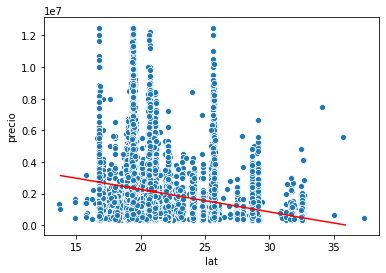

In [96]:
linearRegressorFigure2D(df_train, df_test, 'lat', 'precio')

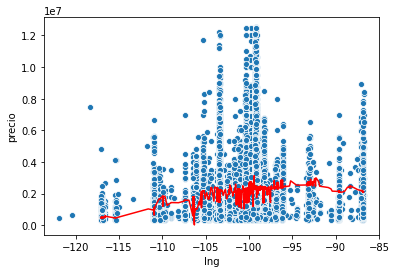

In [97]:
linearRegressorFigure2D(df_train, df_test, 'lng', 'precio')

### Test 5

In [76]:
df_train = pd.read_csv('../data/train.csv')
df_train = df_train[df_train['tipodepropiedad']=='Casa'].dropna()
df_train['patio'] = df_train['metrostotales'] - df_train['metroscubiertos']
df_train = df_train[df_train['patio'] >= 0].dropna()


n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

In [77]:
K = 5
RMSE, RMSLE = linearRegressionKFoldErrors(df_train, ['patio'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)

RMSE:  1439200.2213551216
RMSLE:  0.8471498667700157


In [78]:
linearRegressorPredict(df_train, df_test, ['patio'], 'precio')

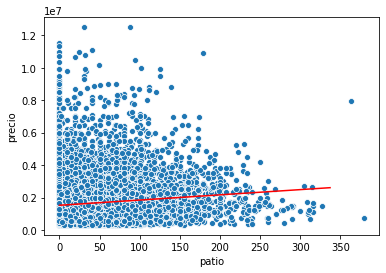

In [79]:
linearRegressorFigure2D(df_train, df_test, 'patio', 'precio')

In [80]:
df_train = pd.read_csv('../data/train.csv')
df_train = df_train[df_train['provincia']=='Distrito Federal'].dropna()
df_train = df_train[df_train['tipodepropiedad']=='Casa'].dropna()
df_train['patio'] = df_train['metrostotales'] - df_train['metroscubiertos']
df_train = df_train[df_train['patio'] >= 0].dropna()


n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

In [81]:
K = 5
RMSE, RMSLE = linearRegressionKFoldErrors(df_train, ['patio'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)

RMSE:  1996423.0090653647
RMSLE:  0.6441636402089173


In [82]:
linearRegressorPredict(df_train, df_test, ['patio'], 'precio')

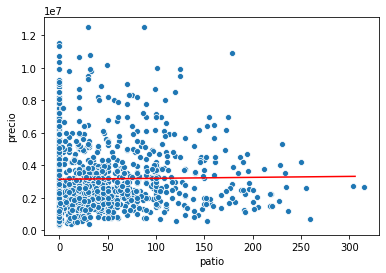

In [83]:
linearRegressorFigure2D(df_train, df_test, 'patio', 'precio')

In [15]:
df_train = pd.read_csv('../data/train.csv')
df_train = df_train[df_train['provincia']=='Jalisco'].dropna()
df_train = df_train[df_train['tipodepropiedad']=='Casa'].dropna()
df_train['patio'] = df_train['metrostotales'] - df_train['metroscubiertos']
df_train = df_train[df_train['patio'] >= 0].dropna()

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

In [16]:
K = 5
RMSE, RMSLE = linearRegressionKFoldErrors(df_train, ['patio'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)

RMSE:  1285194.8780812006
RMSLE:  0.7893278141212038


In [17]:
linearRegressorPredict(df_train, df_test, ['patio'], 'precio')

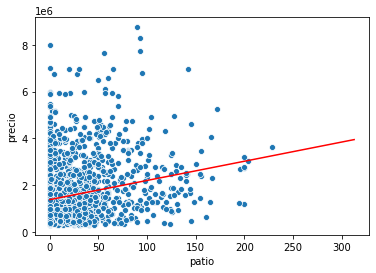

In [18]:
linearRegressorFigure2D(df_train, df_test, 'patio', 'precio')

### Test 6


In [55]:
df_train = pd.read_csv('../data/train.csv')

provincia_info = {
    'provincia':["Aguascalientes", "Baja California Norte", "Baja California Sur", "Campeche", "Coahuila", "Colima", "Chiapas", "Chihuahua", "Distrito Federal", "Durango", "Guanajuato", "Guerrero", "Hidalgo", "Jalisco", "Edo. de México", "Michoacán", "Morelos", "Nayarit", "Nuevo León", "Oaxaca", "Puebla", "Querétaro", "Quintana Roo", "San luis Potosí", "Sinaloa", "Sonora", "Tabasco", "Tamaulipas", "Tlaxcala", "Veracruz", "Yucatán", "Zacatecas"],
    'densidadpoblacional':[233.7, 46.4, 9.6, 15.6, 19.5, 126.4, 71.2, 14.4, 5967.3, 14.2, 191.3, 55.6, 137.3, 99.8, 724.2, 78.2, 390.2, 42.4, 79.8, 42.3, 179.8, 174.4, 33.6, 44.5, 51.7, 15.9, 96.9, 42.9, 318.4, 113.0, 53.1, 21.0],
    'criminalidad': [35.457, 32.758, 25.577, 22.114, 24.800, 27.045, 16.687, 31.274, 52.718, 25.640, 33.154, 53.875, 21.159, 49.317, 56.835, 23.876, 43.419, 21.288, 26.221, 24.961, 27.530, 30.991, 35.639, 25.838, 22.750, 40.466, 30.409, 21.363, 30.699, 22.157, 25.862, 21.501]
}

df_provincia_info = pd.DataFrame(provincia_info, columns = ['provincia', 'densidadpoblacional', 'criminalidad'])

df_train = pd.merge(df_train, df_provincia_info, on = "provincia")

df_train = df_train.sample(frac=1)

df_train = df_train[df_train['densidadpoblacional']<400].dropna()


n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

In [56]:
K = 5
RMSE, RMSLE = linearRegressionKFoldErrors(df_train, ['densidadpoblacional', 'criminalidad'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)

RMSE:  1349117.1010264594
RMSLE:  0.7750995402790832


In [57]:
linearRegressorPredict(df_train, df_test, ['densidadpoblacional', 'criminalidad'], 'precio')

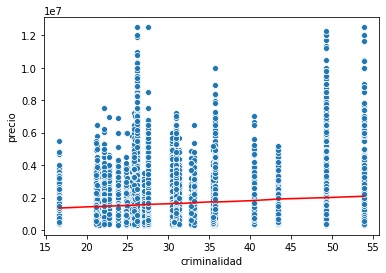

In [58]:
linearRegressorFigure2D(df_train, df_test, 'criminalidad', 'precio')

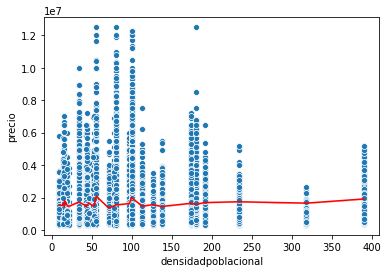

In [59]:
linearRegressorFigure2D(df_train, df_test, 'densidadpoblacional', 'precio')